# 3. Train model (Tensorflow. Raw)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import yaml
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    accuracy_score,
    matthews_corrcoef,
)

## Define constants

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
DATA = os.path.join(ROOT, "data")
PROCESSED_DATA = os.path.join(DATA, "processed") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
GARBAGE_CLASSIFICATION_PATH  = os.path.join(RAW_DATA, "garbage_classification")

### Create folders (if they are not exist)

In [3]:
os.makedirs(PROCESSED_DATA, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

### Set random data

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Load data

### Classes

In [5]:
with open(os.path.join(INTERIM_DATA, "classes.yaml"), "r") as f:
    classes = yaml.safe_load(f)

classes

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

### Datasets

In [6]:
df_train = pd.read_parquet(os.path.join(INTERIM_DATA, "df_train.parquet.gzip"))
df_val = pd.read_parquet(os.path.join(INTERIM_DATA, "df_val.parquet.gzip"))
df_test = pd.read_parquet(os.path.join(INTERIM_DATA, "df_test.parquet.gzip"))

## Transformations

For first iteration, let us not apply any transformations

In [1]:
input_size = 200
BATCH_SIZE = 32

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def load_and_preprocess_image(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [input_size, input_size])
    img = img / 255.0
    img = (img - mean) / std
    
    return img, label

NameError: name 'np' is not defined

## Dataset function

In [8]:
def create_dataset(df, shuffle=False, augment=False):
    # Создаем датасет из путей и меток
    file_paths = df['image_path'].values
    labels = df['class_idx'].values.astype(int)
    
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # Маппинг функции загрузки
    # num_parallel_calls=tf.data.AUTOTUNE позволяет загружать данные параллельно
    ds = ds.map(lambda x, y: load_and_preprocess_image(x, y, augment), 
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

## Create datasets for each dataframe

In [9]:
train_ds = create_dataset(df_train, shuffle=True)
val_ds = create_dataset(df_val, shuffle=False)
test_ds = create_dataset(df_test, shuffle=False)

## Model

Function for setting up the appropriate model's device:

In [ ]:
def get_device() -> str:
    gpus = tf.config.list_physical_devices("GPU")
    if len(gpus) > 0:
        return "GPU"
    return "CPU"

In [ ]:
@tf.keras.saving.register_keras_serializable(package="garbage")
class GarbageClassificationCNN(tf.keras.Model):
    def __init__(self, num_classes=6):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)

        self.conv2 = tf.keras.layers.Conv2D(32, 3, padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding="same")
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(num_classes)  # logits

    def call(self, x, training=False):
        x = self.pool(tf.nn.relu(self.bn1(self.conv1(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn2(self.conv2(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn3(self.conv3(x), training=training)))
        x = self.gap(x)
        x = self.fc(x)
        return x

In [11]:
device_name = get_device()
print(f"Running on {device_name}")

Running on GPU


In [12]:
num_classes = int(df_train["class_idx"].nunique())
model = GarbageClassificationCNN(num_classes=num_classes)

In [13]:
learning_rate = 1e-3
weight_decay = 1e-4

## Criterion and optimizer

In [14]:
optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

## Train and evaluate model

In order to make it reusable, move the logic of model's training and evaluation to separate function:

In [ ]:
def train_eval_model(
    model: keras.Model,
    num_epochs: int,
    best_model_path: str,
    optimizer,
    criterion,
    train_data,
    val_data,
    class_weights=None,
    callbacks=None
) -> pd.DataFrame:
    
    model.compile(optimizer=optimizer,
                  loss=criterion,
                  metrics=['accuracy'])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=best_model_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    
    if callbacks is None:
        callbacks = []
    callbacks.append(checkpoint_cb)

    history = model.fit(
        train_data,
        epochs=num_epochs,
        validation_data=val_data,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = range(len(hist_df))
    
    rename_map = {
        'loss': 'train_loss',
        'accuracy': 'train_acc',
        'val_loss': 'val_loss',
        'val_accuracy': 'val_acc'
    }
    hist_df = hist_df.rename(columns=rename_map)
    
    return hist_df[['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc']]

In [16]:
optimizer = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

df_train_val = train_eval_model(
    model=model,
    num_epochs=60,
    best_model_path=os.path.join(PROCESSED_DATA, "best_model_raw.keras"),
    optimizer=optimizer,
    criterion=criterion,
    train_data=train_ds,
    val_data=val_ds
)

Epoch 1/60
56/56 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.4960
Epoch 1: val_accuracy improved from -inf to 0.35976, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_raw.keras
56/56 [==============================] - 4s 42ms/step - loss: 1.3300 - accuracy: 0.4960 - val_loss: 1.5973 - val_accuracy: 0.3598
Epoch 2/60
55/56 [============================>.] - ETA: 0s - loss: 1.1655 - accuracy: 0.5636
Epoch 2: val_accuracy improved from 0.35976 to 0.36280, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_raw.keras
56/56 [==============================] - 2s 37ms/step - loss: 1.1657 - accuracy: 0.5628 - val_loss: 1.6324 - val_accuracy: 0.3628
Epoch 3/60
55/56 [============================>.] - ETA: 0s - loss: 1.0813 - accuracy: 0.6011
Epoch 3: val_accuracy did not improve from 0.36280
56/56 [==============================] - 2s 36ms/step - loss: 1.0813 - accuracy: 0.6012 - val_loss: 1.83

### Observe results

In [17]:
df_train_val.head(10)

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.329969,0.496041,1.597250,0.359756
1,1,1.165726,0.562783,1.632395,0.362805
2,2,1.081286,0.601244,1.831223,0.356707
3,3,1.107101,0.587670,1.402658,0.417683
4,4,1.044111,0.607466,1.743151,0.368902
5,5,1.045116,0.599548,1.423951,0.426829
6,6,0.996887,0.626131,1.332945,0.466463
7,7,0.985903,0.640271,1.686610,0.411585
8,8,0.985039,0.628959,1.034970,0.615854
9,9,0.954861,0.648756,1.233407,0.548781


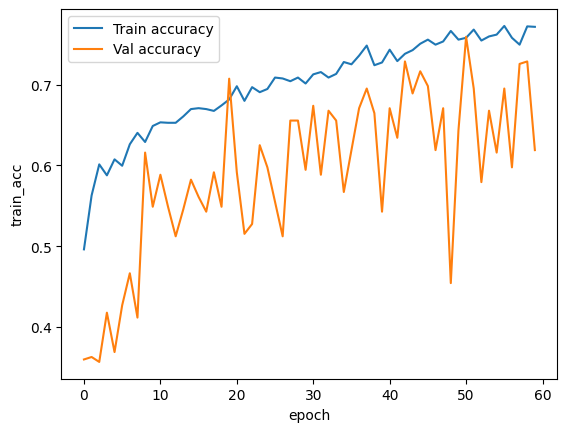

In [18]:
sns.lineplot(data=df_train_val, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_raw_accuracy_default.png")
)
plt.show()

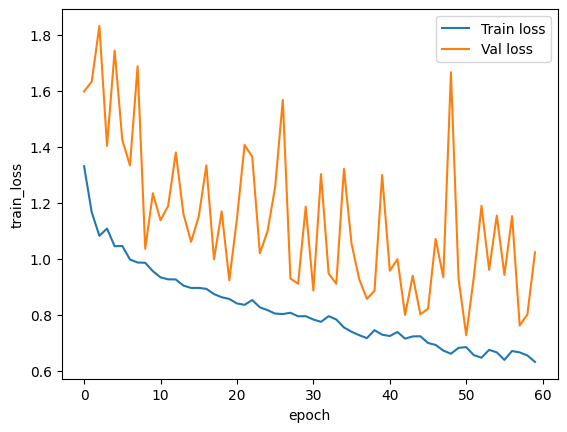

In [19]:
sns.lineplot(data=df_train_val, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_raw_loss_default.png")
)
plt.show()

## Test model

In [ ]:
from typing import Dict, List

def test_model(model: keras.Model, dataset) -> Dict[str, np.ndarray]:
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)
    
    predictions = model.predict(dataset)
    # Argmax для получения класса
    pred_labels = np.argmax(predictions, axis=1)

    return {
        'labels': all_labels,
        'preds': pred_labels
    }

In [ ]:
best_model_path = os.path.join(PROCESSED_DATA, "best_model_raw.keras")
model = tf.keras.models.load_model(
    best_model_path,
)

test_data = test_model(model=model, dataset=test_ds)

14/14 [==============================] - 0s 13ms/step
Test accuracy: 0.7470997679814385


In [ ]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

In [22]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.644     0.793     0.710        82
           1      0.773     0.852     0.811       108
           2      0.932     0.786     0.853        70
           3      0.757     0.716     0.736        74
           4      0.708     0.676     0.692        68
           5      0.647     0.379     0.478        29

    accuracy                          0.747       431
   macro avg      0.743     0.700     0.713       431
weighted avg      0.753     0.747     0.744       431



Confusion matrix:
[[65  3  1  5  8  0]
 [ 3 92  0  4  6  3]
 [ 4  7 55  1  2  1]
 [10  7  1 53  1  2]
 [13  7  0  2 46  0]
 [ 6  3  2  5  2 11]]


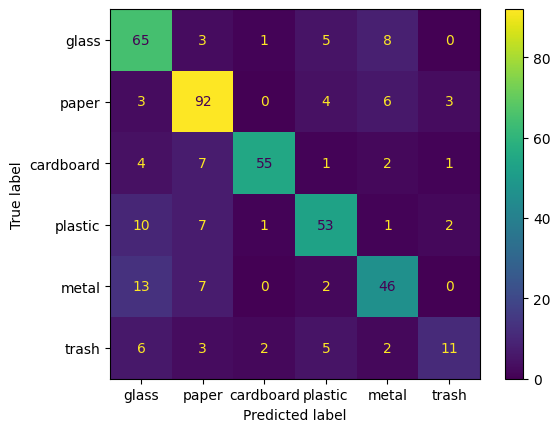

In [23]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "tensorflow_raw_confusion_matrix_default.png"))
plt.show()

### Observations

* Model almost unable to distinguish trash class

## Tune model

For tuning, let us apply these techniques:

* Add transformations to the images
* Sample dataset
* Add classes weights (since model is not able to distunguish `trash`)
* Add early stop for training

In [25]:
raw_model = GarbageClassificationCNN(num_classes=6)

### Add transformations

Let us add appropriate transformations (for trainig dataset only)

In [ ]:
def load_and_augment_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [input_size, input_size])
    img = img / 255.0

    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    img = (img - mean) / std
    return img, label

In [27]:
def create_augmented_dataset(df):
    file_paths = df['image_path'].values
    labels = df['class_idx'].values.astype(int)
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds = ds.map(load_and_augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [28]:
data_augmentation_layers = keras.Sequential([
    layers.RandomRotation(factor=(-10.0/360, 10.0/360)), # +/- 10 градусов
])

### Sample dataset

In [29]:
def augment_batch(x, y):
    x = data_augmentation_layers(x, training=True)
    return x, y

df_trash = df_train[df_train['class'] == 'trash']
# Увеличиваем количество trash в 4 раза
df_train_balanced = pd.concat([df_train, df_trash, df_trash, df_trash], ignore_index=True)
df_train_balanced = df_train_balanced.sample(frac=1).reset_index(drop=True)

# Создаем датасет заново
train_ds_tuned = create_dataset(df_train_balanced, shuffle=True).map(augment_batch)

### Classes weights

In [30]:
class_counts = df_train["class"].value_counts().sort_index()
print(class_counts)

num_classes = class_counts.shape[0]

alpha = 0.5
class_weights_series = (1.0 / class_counts) ** alpha
# normalize, so that average weight is ~1
class_weights_series = class_weights_series / class_weights_series.mean()

print("class_weights:\n", class_weights_series)

# В Keras class_weights передаются как словарь {class_index: weight} в fit()
class_weights_dict = class_weights_series.to_dict()
# Убедимся, что ключи - int
class_weights_dict = {k-1: float(v) for k, v in class_weights_dict.items()}

# Переопределяем оптимайзер для новой модели
optimizer = keras.optimizers.AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
)
criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

class
1    354
2    403
3    287
4    347
5    286
6     91
Name: count, dtype: int64
class_weights:
 class
1    0.840011
2    0.787289
3    0.932923
4    0.848441
5    0.934552
6    1.656784
Name: count, dtype: float64


### Add scheduler

In [31]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', # В PyTorch скрипте scheduler.step(val_loss)
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

### Train model

In [32]:
df_train_val = train_eval_model(
    model=raw_model,
    num_epochs=60,
    best_model_path=os.path.join(PROCESSED_DATA, "best_model_raw.keras"),
    optimizer=optimizer,
    criterion=criterion,
    train_data=train_ds_tuned, # Используем аугментированный датасет
    val_data=val_ds,
    class_weights=class_weights_dict, # Передаем веса классов
    callbacks=[reduce_lr] # Передаем скедулер
)

Epoch 1/60
56/56 [==============================] - ETA: 0s - loss: 1.2346 - accuracy: 0.4678
Epoch 1: val_accuracy improved from -inf to 0.38415, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_raw.keras
56/56 [==============================] - 4s 43ms/step - loss: 1.2346 - accuracy: 0.4678 - val_loss: 1.6620 - val_accuracy: 0.3841 - lr: 0.0010
Epoch 2/60
55/56 [============================>.] - ETA: 0s - loss: 1.1095 - accuracy: 0.5131
Epoch 2: val_accuracy did not improve from 0.38415
56/56 [==============================] - 3s 37ms/step - loss: 1.1083 - accuracy: 0.5136 - val_loss: 1.5732 - val_accuracy: 0.2988 - lr: 0.0010
Epoch 3/60
55/56 [============================>.] - ETA: 0s - loss: 1.0579 - accuracy: 0.5506
Epoch 3: val_accuracy improved from 0.38415 to 0.41463, saving model to /Users/vadim.sokoltsov/learning/bin-it-right/data/processed/best_model_raw.keras
56/56 [==============================] - 3s 38ms/step - loss: 1.0561 - accurac

### Visualize results

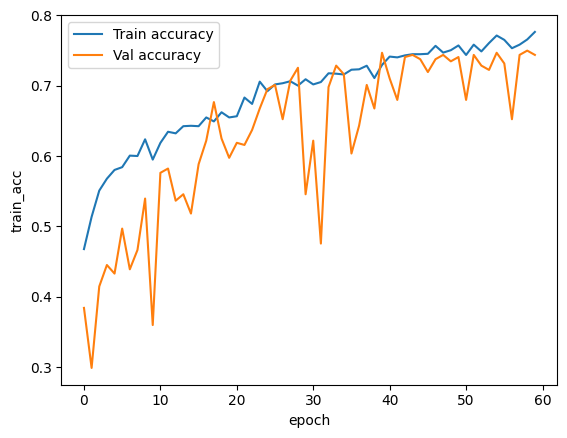

In [33]:
sns.lineplot(data=df_train_val, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_raw_accuracy_tuned.png")
)
plt.show()

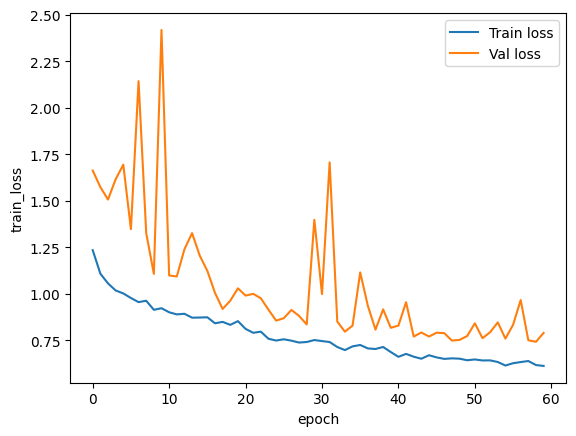

In [34]:
sns.lineplot(data=df_train_val, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "tensorflow_raw_loss_tuned.png")
)
plt.show()

### Test model

In [ ]:
tuned_model_path = os.path.join(PROCESSED_DATA, "best_model_raw.keras")
model = tf.keras.models.load_model(
    tuned_model_path,
    compile=False
)

test_data = test_model(model=model, dataset=test_ds)

14/14 [==============================] - 0s 10ms/step
Test accuracy: 0.7470997679814385


In [ ]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

In [36]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.757     0.683     0.718        82
           1      0.815     0.815     0.815       108
           2      0.887     0.900     0.894        70
           3      0.644     0.757     0.696        74
           4      0.740     0.544     0.627        68
           5      0.537     0.759     0.629        29

    accuracy                          0.747       431
   macro avg      0.730     0.743     0.730       431
weighted avg      0.756     0.747     0.747       431



Confusion matrix:
[[56  3  3 12  6  2]
 [ 1 88  0  7  3  9]
 [ 0  4 63  1  2  0]
 [ 6  6  3 56  1  2]
 [ 9  6  2  8 37  6]
 [ 2  1  0  3  1 22]]


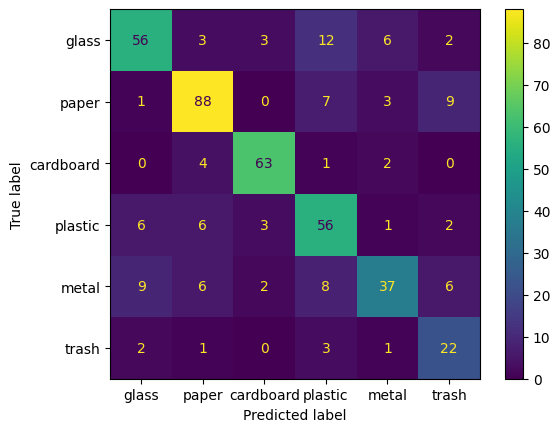

In [37]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "tensorflow_raw_confusion_matrix_tuned.png"))
plt.show()

          accuracy: 0.7471
 balanced_accuracy: 0.7429
          macro_f1: 0.7296
       weighted_f1: 0.7466
          micro_f1: 0.7471
   macro_precision: 0.7299
      macro_recall: 0.7429
               mcc: 0.6926


### Observations

* After tuning accuracy has not improvement, but classes distribution has improved